### Reproducing the Results from a Genetic Algorithm with a Neaural Network

This notebook aims to reproduce the output data of *Multi-Objective Optimization of Turning Process during Machining of AlMg1SiCu (Aluminum) Using Non-Dominated Sorted Genetic Algorithm* by Rahul Dhabalea, VijayKumar S. Jattib, and T.P.Singhc. The study used a genetic algorithm to generate novel cutting parameters, and predict material removal rate & surface roughness, based on the input of twenty-seven rows of cutting data conataining the same parameters. The study can be found [here](https://www.sciencedirect.com/science/article/pii/S2211812814005318) for further reading but some explanation will follow, mainly concerning the differences between goals and the methodology used in creating the neural network.

As mentioned above, the genetic algorithm took twenty-seven rows of data as input parameters. These were a series of test cuts where a CNC machine tool was set to turn a constant diameter at a designated spindle speed (rpm), feed rate (mm/rev), and depth of cut(mm). The results of each test cut take the form of a calculated material remove rate (mm$^3$/min) and surface roughness (μm) measurement.



In [7]:
# import dependencies
%matplotlib inline
import keras
from keras.models import Sequential
from keras.activations import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import talos as ta
import warnings
warnings.filterwarnings("ignore")

# suppress NumPy arrays scientific notation and round decimals to three places
np.set_printoptions(suppress=True)
np.printoptions(precision=3, suppress=True)

print('Dependency Versions:\n')
print('Keras', keras.__version__)
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Seaborn', sns.__version__)
print('Sklearn', sklearn.__version__)
print('Talos', ta.__version__)

Dependency Versions:

Keras 2.2.4
Numpy 1.17.0
Pandas 0.24.2
Seaborn 0.9.0
Sklearn 0.20.3
Talos 0.6.0


In [8]:
# import training data
data = pd.read_csv('data.txt', delim_whitespace=True, encoding='ISO-8859-1')
data.drop(columns=['Sr._No.'], inplace=True)

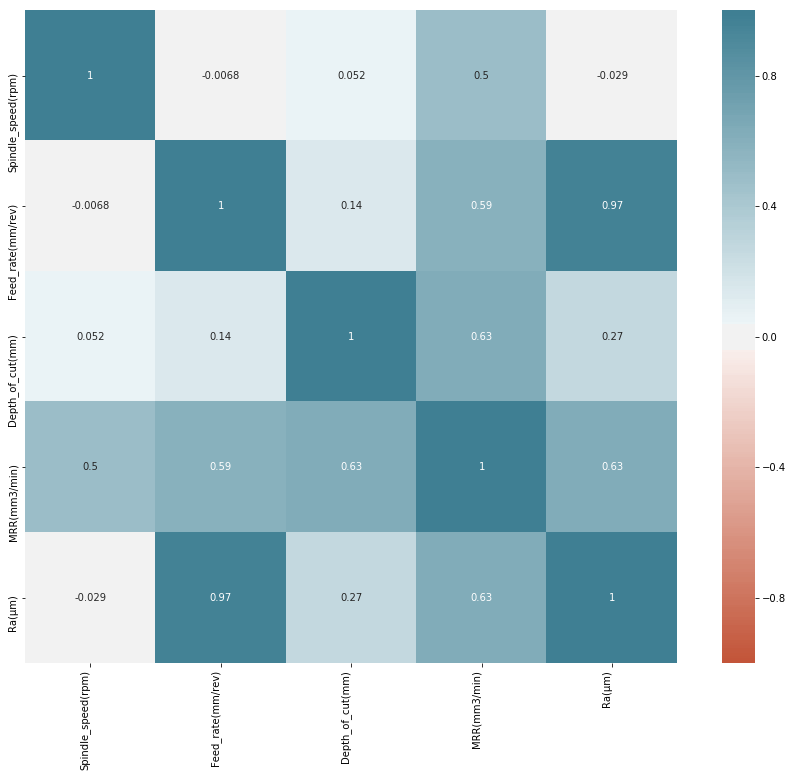

In [9]:
# a look at the overall correlation between training and testing data
heat_data = data
plt.figure(figsize=(16, 12))
corr = heat_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
plt.savefig('heatmap')

In [10]:
# change the dataframe into a NumPy array
np_data = data.values

In [11]:
# Transforms features by scaling each feature to a given range, -1 and 1 in this case
MinMax_scaler = MinMaxScaler(feature_range=(-1, 1))
np_data_MinMax = MinMax_scaler.fit_transform(np_data)

In [12]:
# Standardize features by removing the mean and scaling to unit variance
Standard_scaler = StandardScaler()
np_data_Standard = Standard_scaler.fit_transform(np_data)

In [13]:
# split the scaled data into training, testing, and validation sets
train_features_MinMax = np_data_MinMax[0:27 , 3:5]
test_features_MinMax = np_data_MinMax[28:32, 3:5]
validation_features_MinMax = np_data_MinMax[27, 3:5]
train_labels_MinMax = np_data_MinMax[0:27, 0:3]
test_labels_MinMax = np_data_MinMax[28:32, 0:3]
validation_labels_MinMax = np_data_MinMax[27, 0:3]

# reshape the validation data because it's only one row
validation_features_MinMax = validation_features_MinMax.reshape(1, -1)
validation_labels_MinMax = validation_labels_MinMax.reshape(1, -1)

In [14]:
# split the scaled data into training, testing, and validation sets
train_features_Standard = np_data_Standard[0:27 , 3:5]
test_features_Standard = np_data_Standard[28:32, 3:5]
validation_features_Standard = np_data_Standard[27, 3:5]
train_labels_Standard = np_data_Standard[0:27, 0:3]
test_labels_Standard = np_data_Standard[28:32, 0:3]
validation_labels_Standard = np_data_Standard[27, 0:3]

# reshape the validation data because it's only one row
validation_features_Standard = validation_features_Standard.reshape(1, -1)
validation_labels_Standard = validation_labels_Standard.reshape(1, -1)

In [15]:
# combining original the testing group to compare against rescaled groups below
np_test_data = np.concatenate([np_data[28:32, 0:3], np_data[28:32, 3:5]], axis=1)
np_test_data

array([[1100.  ,    0.05,    0.69, 2020.44,    0.29],
       [1095.  ,    0.15,    1.2 , 6054.12,    1.87],
       [1097.  ,    0.13,    1.14, 5329.21,    1.54],
       [1094.  ,    0.12,    1.15, 5197.29,    1.45]])

In [16]:
# combine the MinMax testing group and rescale
test_data_MinMax = np.concatenate([test_labels_MinMax, test_features_MinMax], axis=1)
MinMax_scaler.inverse_transform(test_data_MinMax)

array([[1100.  ,    0.05,    0.69, 2020.44,    0.29],
       [1095.  ,    0.15,    1.2 , 6054.12,    1.87],
       [1097.  ,    0.13,    1.14, 5329.21,    1.54],
       [1094.  ,    0.12,    1.15, 5197.29,    1.45]])

In [17]:
# combine the Standard testing group and rescale
test_data_Standard = np.concatenate([test_labels_Standard, test_features_Standard], axis=1)
Standard_scaler.inverse_transform(test_data_Standard)

array([[1100.  ,    0.05,    0.69, 2020.44,    0.29],
       [1095.  ,    0.15,    1.2 , 6054.12,    1.87],
       [1097.  ,    0.13,    1.14, 5329.21,    1.54],
       [1094.  ,    0.12,    1.15, 5197.29,    1.45]])

In [ ]:
# parameters to try during Talos optimization
p = {
    'first_neuron': [8, 12, 24],
    'second_neuron': [36, 48, 62],
    'third_neuron': [36, 48, 62],
    'fourth_neuron': [8, 12, 24],
    'batch_size': [10, 20, 30],
    'activation': [relu,
                   tanh,
                   linear],
    'optimizer' : ['Adam',],
    'loss' : [mean_squared_error,]
}

In [ ]:
def MinMax_ann(train_features, train_labels, test_features, test_labels, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=2, activation=params['activation']))
    model.add(Dense(params['second_neuron'], activation=params['activation']))
    model.add(Dense(params['third_neuron'], activation=params['activation']))
    model.add(Dense(params['fourth_neuron'], activation=params['activation']))
    model.add(Dense(3, activation='linear'))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(train_features_MinMax, train_labels_MinMax,
                    epochs=1000,
                    batch_size=params['batch_size'],
                    verbose=0,
                    validation_data=[test_features_MinMax, test_labels_MinMax])
    
    # model output
    return out, model

In [ ]:
def Standard_ann(train_features, train_labels, test_features, test_labels, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=2, activation=params['activation']))
    model.add(Dense(params['second_neuron'], activation=params['activation']))
    model.add(Dense(params['third_neuron'], activation=params['activation']))
    model.add(Dense(params['fourth_neuron'], activation=params['activation']))
    model.add(Dense(3, activation='linear'))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(train_features_Standard, train_labels_Standard,
                    epochs=1000,
                    batch_size=params['batch_size'],
                    verbose=0,
                    validation_data=[test_features_Standard, test_labels_Standard])
    
    # model output
    return out, model

In [18]:
# combine MinMax training and test features, and training and test labels for Talos experiment
features_MinMax = np.concatenate((train_features_MinMax, test_features_MinMax), axis=0)
labels_MinMax = np.concatenate((train_labels_MinMax, test_labels_MinMax), axis=0)

In [19]:
# combine Standard training and test features, and training and test labels for Talos experiment
features_Standard = np.concatenate((train_features_Standard, test_features_Standard), axis=0)
labels_Standard = np.concatenate((train_labels_Standard, test_labels_Standard), axis=0)

In [47]:
# run the Talos experiment on MinMax data
MinMax_t = ta.Scan(features_MinMax, labels_MinMax, 
            params=p, 
            model=MinMax_ann,
            )

100%|██████████████████████████████████████████████████████████████████████████████| 729/729 [1:30:06<00:00,  2.43s/it]


In [48]:
# run the Talos experiment on Standard data
MinMax_t = ta.Scan(features_Standard, labels_Standard, 
            params=p, 
            model=Standard_ann,
            )

100%|████████████████████████████████████████████████████████████████████████████████| 729/729 [40:45<00:00,  2.46s/it]


In [20]:
# Define the MinMax model
MinMax_model = Sequential()
MinMax_model.add(Dense(24, input_dim=2, activation='relu'))
MinMax_model.add(Dense(36, activation='relu'))
MinMax_model.add(Dense(62, activation='relu'))
MinMax_model.add(Dense(8, activation='relu'))
MinMax_model.add(Dense(3, activation='linear'))
MinMax_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

MinMax_model.fit(train_features_MinMax,
                 train_labels_MinMax,
                 validation_data=(test_features_MinMax, test_labels_MinMax),
                 batch_size=20,
                 epochs=1000)

W0822 07:19:23.811215 15344 deprecation_wrapper.py:119] From C:\Users\MacalusoC\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 07:19:23.857813 15344 deprecation_wrapper.py:119] From C:\Users\MacalusoC\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 07:19:23.857813 15344 deprecation_wrapper.py:119] From C:\Users\MacalusoC\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 07:19:23.937173 15344 deprecation_wrapper.py:119] From C:\Users\MacalusoC\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.comp

Train on 27 samples, validate on 4 samples
Epoch 1/1000
27/27 [==============================] - 1s 23ms/step - loss: 0.6351 - acc: 0.6296 - val_loss: 0.6790 - val_acc: 0.2500
Epoch 2/1000
27/27 [==============================] - 0s 0us/step - loss: 0.6198 - acc: 0.6296 - val_loss: 0.6672 - val_acc: 0.2500
Epoch 3/1000
27/27 [==============================] - 0s 577us/step - loss: 0.6065 - acc: 0.5926 - val_loss: 0.6568 - val_acc: 0.2500
Epoch 4/1000
27/27 [==============================] - 0s 0us/step - loss: 0.5960 - acc: 0.5926 - val_loss: 0.6441 - val_acc: 0.2500
Epoch 5/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5847 - acc: 0.5926 - val_loss: 0.6303 - val_acc: 0.2500
Epoch 6/1000
27/27 [==============================] - 0s 0us/step - loss: 0.5744 - acc: 0.5926 - val_loss: 0.6177 - val_acc: 0.2500
Epoch 7/1000
27/27 [==============================] - 0s 579us/step - loss: 0.5638 - acc: 0.5926 - val_loss: 0.6059 - val_acc: 0.2500
Epoch 8/1000
27/27 [========

Epoch 62/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2513 - acc: 0.6296 - val_loss: 0.1192 - val_acc: 0.2500
Epoch 63/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2511 - acc: 0.5926 - val_loss: 0.1136 - val_acc: 0.2500
Epoch 64/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2515 - acc: 0.5926 - val_loss: 0.1082 - val_acc: 0.2500
Epoch 65/1000
27/27 [==============================] - 0s 578us/step - loss: 0.2517 - acc: 0.5926 - val_loss: 0.1057 - val_acc: 0.2500
Epoch 66/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2538 - acc: 0.5926 - val_loss: 0.1063 - val_acc: 0.2500
Epoch 67/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2528 - acc: 0.5926 - val_loss: 0.1109 - val_acc: 0.2500
Epoch 68/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2516 - acc: 0.5926 - val_loss: 0.1150 - val_acc: 0.2500
Epoch 69/1000
27/27 [==============================] - 0s 579us/ste

27/27 [==============================] - 0s 0us/step - loss: 0.2308 - acc: 0.5926 - val_loss: 0.1113 - val_acc: 0.2500
Epoch 124/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2318 - acc: 0.5926 - val_loss: 0.1102 - val_acc: 0.2500
Epoch 125/1000
27/27 [==============================] - 0s 579us/step - loss: 0.2317 - acc: 0.5926 - val_loss: 0.1080 - val_acc: 0.2500
Epoch 126/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2307 - acc: 0.5926 - val_loss: 0.1081 - val_acc: 0.2500
Epoch 127/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2298 - acc: 0.5926 - val_loss: 0.1080 - val_acc: 0.2500
Epoch 128/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2287 - acc: 0.5926 - val_loss: 0.1117 - val_acc: 0.2500
Epoch 129/1000
27/27 [==============================] - 0s 579us/step - loss: 0.2288 - acc: 0.5926 - val_loss: 0.1128 - val_acc: 0.2500
Epoch 130/1000
27/27 [==============================] - 0s 0us/step - los

27/27 [==============================] - 0s 580us/step - loss: 0.2078 - acc: 0.6667 - val_loss: 0.1197 - val_acc: 0.2500
Epoch 185/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2082 - acc: 0.6667 - val_loss: 0.1187 - val_acc: 0.2500
Epoch 186/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2071 - acc: 0.6296 - val_loss: 0.1189 - val_acc: 0.2500
Epoch 187/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2057 - acc: 0.6667 - val_loss: 0.1226 - val_acc: 0.2500
Epoch 188/1000
27/27 [==============================] - 0s 578us/step - loss: 0.2064 - acc: 0.6667 - val_loss: 0.1247 - val_acc: 0.2500
Epoch 189/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2065 - acc: 0.6667 - val_loss: 0.1242 - val_acc: 0.2500
Epoch 190/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2062 - acc: 0.6667 - val_loss: 0.1213 - val_acc: 0.2500
Epoch 191/1000
27/27 [==============================] - 0s 578us/step - l

Epoch 245/1000
27/27 [==============================] - 0s 577us/step - loss: 0.1778 - acc: 0.6667 - val_loss: 0.1341 - val_acc: 0.5000
Epoch 246/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1739 - acc: 0.7037 - val_loss: 0.1252 - val_acc: 0.7500
Epoch 247/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1764 - acc: 0.6667 - val_loss: 0.1198 - val_acc: 0.7500
Epoch 248/1000
27/27 [==============================] - 0s 579us/step - loss: 0.1746 - acc: 0.7037 - val_loss: 0.1206 - val_acc: 0.7500
Epoch 249/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1728 - acc: 0.7407 - val_loss: 0.1241 - val_acc: 0.7500
Epoch 250/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1706 - acc: 0.7037 - val_loss: 0.1326 - val_acc: 0.5000
Epoch 251/1000
27/27 [==============================] - 0s 579us/step - loss: 0.1711 - acc: 0.7037 - val_loss: 0.1415 - val_acc: 0.5000
Epoch 252/1000
27/27 [==============================] - 

27/27 [==============================] - 0s 0us/step - loss: 0.1416 - acc: 0.7037 - val_loss: 0.1755 - val_acc: 0.7500
Epoch 306/1000
27/27 [==============================] - 0s 578us/step - loss: 0.1421 - acc: 0.6667 - val_loss: 0.1725 - val_acc: 0.7500
Epoch 307/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1415 - acc: 0.7037 - val_loss: 0.1642 - val_acc: 0.7500
Epoch 308/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1396 - acc: 0.7407 - val_loss: 0.1603 - val_acc: 0.7500
Epoch 309/1000
27/27 [==============================] - 0s 580us/step - loss: 0.1394 - acc: 0.7778 - val_loss: 0.1603 - val_acc: 0.7500
Epoch 310/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1396 - acc: 0.7407 - val_loss: 0.1637 - val_acc: 0.7500
Epoch 311/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1381 - acc: 0.7407 - val_loss: 0.1665 - val_acc: 0.5000
Epoch 312/1000
27/27 [==============================] - 0s 577us/step - l

Epoch 366/1000
27/27 [==============================] - 0s 579us/step - loss: 0.1108 - acc: 0.7037 - val_loss: 0.1925 - val_acc: 0.7500
Epoch 367/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1091 - acc: 0.7037 - val_loss: 0.1879 - val_acc: 0.7500
Epoch 368/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1109 - acc: 0.7037 - val_loss: 0.1873 - val_acc: 0.7500
Epoch 369/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1093 - acc: 0.7407 - val_loss: 0.1953 - val_acc: 0.7500
Epoch 370/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1061 - acc: 0.7407 - val_loss: 0.2079 - val_acc: 0.7500
Epoch 371/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1068 - acc: 0.7037 - val_loss: 0.2283 - val_acc: 0.5000
Epoch 372/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1138 - acc: 0.7037 - val_loss: 0.2462 - val_acc: 0.5000
Epoch 373/1000
27/27 [==============================] - 0s 5

27/27 [==============================] - 0s 0us/step - loss: 0.0818 - acc: 0.8519 - val_loss: 0.2480 - val_acc: 0.7500
Epoch 427/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0812 - acc: 0.7778 - val_loss: 0.2462 - val_acc: 0.7500
Epoch 428/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0807 - acc: 0.7778 - val_loss: 0.2451 - val_acc: 0.7500
Epoch 429/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0806 - acc: 0.7778 - val_loss: 0.2423 - val_acc: 0.7500
Epoch 430/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0813 - acc: 0.7778 - val_loss: 0.2422 - val_acc: 0.7500
Epoch 431/1000
27/27 [==============================] - 0s 578us/step - loss: 0.0789 - acc: 0.7407 - val_loss: 0.2461 - val_acc: 0.7500
Epoch 432/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0800 - acc: 0.8519 - val_loss: 0.2545 - val_acc: 0.7500
Epoch 433/1000
27/27 [==============================] - 0s 0us/step - los

Epoch 487/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0610 - acc: 0.7778 - val_loss: 0.3202 - val_acc: 0.5000
Epoch 488/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0591 - acc: 0.8519 - val_loss: 0.3196 - val_acc: 0.7500
Epoch 489/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0593 - acc: 0.8519 - val_loss: 0.3059 - val_acc: 0.7500
Epoch 490/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0589 - acc: 0.8519 - val_loss: 0.2981 - val_acc: 0.7500
Epoch 491/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0586 - acc: 0.7778 - val_loss: 0.3073 - val_acc: 0.2500
Epoch 492/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0617 - acc: 0.7407 - val_loss: 0.3220 - val_acc: 0.5000
Epoch 493/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0617 - acc: 0.7407 - val_loss: 0.3342 - val_acc: 0.5000
Epoch 494/1000
27/27 [==============================] - 0s

Epoch 548/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0450 - acc: 0.7778 - val_loss: 0.3382 - val_acc: 0.7500
Epoch 549/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0446 - acc: 0.8148 - val_loss: 0.3432 - val_acc: 0.7500
Epoch 550/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0457 - acc: 0.7407 - val_loss: 0.3546 - val_acc: 0.5000
Epoch 551/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0476 - acc: 0.7778 - val_loss: 0.3594 - val_acc: 0.7500
Epoch 552/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0451 - acc: 0.8889 - val_loss: 0.3593 - val_acc: 0.7500
Epoch 553/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0451 - acc: 0.8889 - val_loss: 0.3405 - val_acc: 0.7500
Epoch 554/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0435 - acc: 0.8148 - val_loss: 0.3237 - val_acc: 0.7500
Epoch 555/1000
27/27 [==============================] - 0s

27/27 [==============================] - 0s 579us/step - loss: 0.0360 - acc: 0.7407 - val_loss: 0.3417 - val_acc: 0.7500
Epoch 609/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0360 - acc: 0.7778 - val_loss: 0.3455 - val_acc: 0.7500
Epoch 610/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0371 - acc: 0.8519 - val_loss: 0.3527 - val_acc: 0.7500
Epoch 611/1000
27/27 [==============================] - 0s 580us/step - loss: 0.0361 - acc: 0.8519 - val_loss: 0.3595 - val_acc: 0.7500
Epoch 612/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0359 - acc: 0.8148 - val_loss: 0.3609 - val_acc: 0.7500
Epoch 613/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0372 - acc: 0.7037 - val_loss: 0.3587 - val_acc: 0.7500
Epoch 614/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0365 - acc: 0.7037 - val_loss: 0.3604 - val_acc: 0.7500
Epoch 615/1000
27/27 [==============================] - 0s 0us/step - l

27/27 [==============================] - 0s 0us/step - loss: 0.0307 - acc: 0.8889 - val_loss: 0.4124 - val_acc: 0.7500
Epoch 669/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0308 - acc: 0.8519 - val_loss: 0.3941 - val_acc: 0.7500
Epoch 670/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0330 - acc: 0.7407 - val_loss: 0.3860 - val_acc: 0.7500
Epoch 671/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0324 - acc: 0.6667 - val_loss: 0.3911 - val_acc: 0.7500
Epoch 672/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0300 - acc: 0.7407 - val_loss: 0.4038 - val_acc: 0.7500
Epoch 673/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0318 - acc: 0.8519 - val_loss: 0.4024 - val_acc: 0.7500
Epoch 674/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0310 - acc: 0.8148 - val_loss: 0.3926 - val_acc: 0.7500
Epoch 675/1000
27/27 [==============================] - ETA: 0s - loss: 0

Epoch 729/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0259 - acc: 0.8519 - val_loss: 0.4443 - val_acc: 0.7500
Epoch 730/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0266 - acc: 0.8889 - val_loss: 0.4342 - val_acc: 0.7500
Epoch 731/1000
27/27 [==============================] - 0s 577us/step - loss: 0.0253 - acc: 0.8889 - val_loss: 0.4051 - val_acc: 0.7500
Epoch 732/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0252 - acc: 0.7037 - val_loss: 0.3948 - val_acc: 0.7500
Epoch 733/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0257 - acc: 0.7037 - val_loss: 0.4141 - val_acc: 0.7500
Epoch 734/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0256 - acc: 0.8148 - val_loss: 0.4322 - val_acc: 0.7500
Epoch 735/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0256 - acc: 0.8889 - val_loss: 0.4324 - val_acc: 0.7500
Epoch 736/1000
27/27 [==============================] - 0s 0

Epoch 790/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0225 - acc: 0.6667 - val_loss: 0.4431 - val_acc: 0.7500
Epoch 791/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0222 - acc: 0.6667 - val_loss: 0.4682 - val_acc: 0.7500
Epoch 792/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0221 - acc: 0.8148 - val_loss: 0.4865 - val_acc: 0.7500
Epoch 793/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0223 - acc: 0.8148 - val_loss: 0.4924 - val_acc: 0.7500
Epoch 794/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0227 - acc: 0.8148 - val_loss: 0.4809 - val_acc: 0.7500
Epoch 795/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0225 - acc: 0.8519 - val_loss: 0.4583 - val_acc: 0.7500
Epoch 796/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0227 - acc: 0.8148 - val_loss: 0.4599 - val_acc: 0.7500
Epoch 797/1000
27/27 [==============================] - 0s

Epoch 851/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0199 - acc: 0.8519 - val_loss: 0.4618 - val_acc: 0.7500
Epoch 852/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0200 - acc: 0.7407 - val_loss: 0.4557 - val_acc: 0.7500
Epoch 853/1000
27/27 [==============================] - 0s 580us/step - loss: 0.0229 - acc: 0.7407 - val_loss: 0.4651 - val_acc: 0.7500
Epoch 854/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0211 - acc: 0.7778 - val_loss: 0.4807 - val_acc: 0.7500
Epoch 855/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0193 - acc: 0.7778 - val_loss: 0.4912 - val_acc: 0.7500
Epoch 856/1000
27/27 [==============================] - 0s 577us/step - loss: 0.0203 - acc: 0.7407 - val_loss: 0.4763 - val_acc: 0.7500
Epoch 857/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0200 - acc: 0.6296 - val_loss: 0.4691 - val_acc: 0.7500
Epoch 858/1000
27/27 [==============================] - 0s

27/27 [==============================] - 0s 0us/step - loss: 0.0174 - acc: 0.6296 - val_loss: 0.4784 - val_acc: 0.7500
Epoch 912/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0184 - acc: 0.6667 - val_loss: 0.5023 - val_acc: 0.7500
Epoch 913/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0187 - acc: 0.8889 - val_loss: 0.4912 - val_acc: 0.7500
Epoch 914/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0176 - acc: 0.8519 - val_loss: 0.4595 - val_acc: 0.7500
Epoch 915/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0168 - acc: 0.6667 - val_loss: 0.4540 - val_acc: 0.7500
Epoch 916/1000
27/27 [==============================] - 0s 577us/step - loss: 0.0180 - acc: 0.6667 - val_loss: 0.4657 - val_acc: 0.7500
Epoch 917/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0168 - acc: 0.7037 - val_loss: 0.4749 - val_acc: 0.7500
Epoch 918/1000
27/27 [==============================] - 0s 0us/step - los

27/27 [==============================] - 0s 0us/step - loss: 0.0167 - acc: 0.8889 - val_loss: 0.5313 - val_acc: 0.7500
Epoch 973/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0157 - acc: 0.8148 - val_loss: 0.4992 - val_acc: 0.7500
Epoch 974/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0154 - acc: 0.6296 - val_loss: 0.4754 - val_acc: 0.7500
Epoch 975/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0154 - acc: 0.5926 - val_loss: 0.4867 - val_acc: 0.7500
Epoch 976/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0153 - acc: 0.7778 - val_loss: 0.5013 - val_acc: 0.7500
Epoch 977/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0157 - acc: 0.8148 - val_loss: 0.4943 - val_acc: 0.7500
Epoch 978/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0148 - acc: 0.7778 - val_loss: 0.4776 - val_acc: 0.7500
Epoch 979/1000
27/27 [==============================] - 0s 578us/step - l

In [21]:
# Define the Standard model
Standard_model = Sequential()
Standard_model.add(Dense(12, input_dim=2, activation='relu'))
Standard_model.add(Dense(48, activation='relu'))
Standard_model.add(Dense(36, activation='relu'))
Standard_model.add(Dense(8, activation='relu'))
Standard_model.add(Dense(3, activation='linear'))
Standard_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

Standard_model.fit(train_features_Standard,
                 train_labels_Standard,
                 validation_data=(test_features_Standard, test_labels_Standard),
                 batch_size=30,
                 epochs=1000)

Train on 27 samples, validate on 4 samples
Epoch 1/1000
27/27 [==============================] - 1s 23ms/step - loss: 0.9859 - acc: 0.3333 - val_loss: 0.9482 - val_acc: 0.0000e+00
Epoch 2/1000
27/27 [==============================] - 0s 577us/step - loss: 0.9775 - acc: 0.3333 - val_loss: 0.9413 - val_acc: 0.2500
Epoch 3/1000
27/27 [==============================] - 0s 0us/step - loss: 0.9682 - acc: 0.4815 - val_loss: 0.9355 - val_acc: 0.2500
Epoch 4/1000
27/27 [==============================] - 0s 0us/step - loss: 0.9590 - acc: 0.4815 - val_loss: 0.9295 - val_acc: 0.2500
Epoch 5/1000
27/27 [==============================] - 0s 579us/step - loss: 0.9500 - acc: 0.4815 - val_loss: 0.9237 - val_acc: 0.2500
Epoch 6/1000
27/27 [==============================] - 0s 0us/step - loss: 0.9406 - acc: 0.4815 - val_loss: 0.9181 - val_acc: 0.2500
Epoch 7/1000
27/27 [==============================] - 0s 0us/step - loss: 0.9318 - acc: 0.4815 - val_loss: 0.9123 - val_acc: 0.2500
Epoch 8/1000
27/27 [====

27/27 [==============================] - 0s 579us/step - loss: 0.5706 - acc: 0.5185 - val_loss: 0.5407 - val_acc: 0.5000
Epoch 63/1000
27/27 [==============================] - 0s 0us/step - loss: 0.5641 - acc: 0.5185 - val_loss: 0.5309 - val_acc: 0.5000
Epoch 64/1000
27/27 [==============================] - 0s 0us/step - loss: 0.5575 - acc: 0.5556 - val_loss: 0.5197 - val_acc: 0.5000
Epoch 65/1000
27/27 [==============================] - 0s 578us/step - loss: 0.5510 - acc: 0.5556 - val_loss: 0.5085 - val_acc: 0.5000
Epoch 66/1000
27/27 [==============================] - 0s 0us/step - loss: 0.5445 - acc: 0.5556 - val_loss: 0.4977 - val_acc: 0.5000
Epoch 67/1000
27/27 [==============================] - 0s 0us/step - loss: 0.5380 - acc: 0.5556 - val_loss: 0.4867 - val_acc: 0.5000
Epoch 68/1000
27/27 [==============================] - 0s 579us/step - loss: 0.5316 - acc: 0.5556 - val_loss: 0.4756 - val_acc: 0.5000
Epoch 69/1000
27/27 [==============================] - 0s 0us/step - loss: 0.

Epoch 124/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3587 - acc: 0.6667 - val_loss: 0.1542 - val_acc: 0.5000
Epoch 125/1000
27/27 [==============================] - 0s 579us/step - loss: 0.3578 - acc: 0.6667 - val_loss: 0.1521 - val_acc: 0.5000
Epoch 126/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3567 - acc: 0.6667 - val_loss: 0.1497 - val_acc: 0.5000
Epoch 127/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3554 - acc: 0.6667 - val_loss: 0.1475 - val_acc: 0.5000
Epoch 128/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3541 - acc: 0.6667 - val_loss: 0.1462 - val_acc: 0.5000
Epoch 129/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3532 - acc: 0.6667 - val_loss: 0.1458 - val_acc: 0.5000
Epoch 130/1000
27/27 [==============================] - 0s 579us/step - loss: 0.3521 - acc: 0.6667 - val_loss: 0.1463 - val_acc: 0.5000
Epoch 131/1000
27/27 [==============================] - 0s

Epoch 185/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2933 - acc: 0.7407 - val_loss: 0.1706 - val_acc: 0.5000
Epoch 186/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2925 - acc: 0.7407 - val_loss: 0.1714 - val_acc: 0.7500
Epoch 187/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2917 - acc: 0.7407 - val_loss: 0.1719 - val_acc: 0.7500
Epoch 188/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2908 - acc: 0.7407 - val_loss: 0.1721 - val_acc: 0.5000
Epoch 189/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2900 - acc: 0.7407 - val_loss: 0.1731 - val_acc: 0.5000
Epoch 190/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2892 - acc: 0.7407 - val_loss: 0.1752 - val_acc: 0.5000
Epoch 191/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2882 - acc: 0.7407 - val_loss: 0.1776 - val_acc: 0.5000
Epoch 192/1000
27/27 [==============================] - 0s 579

27/27 [==============================] - 0s 579us/step - loss: 0.2441 - acc: 0.7778 - val_loss: 0.1980 - val_acc: 0.2500
Epoch 247/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2431 - acc: 0.7778 - val_loss: 0.1985 - val_acc: 0.2500
Epoch 248/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2422 - acc: 0.7778 - val_loss: 0.2001 - val_acc: 0.2500
Epoch 249/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2414 - acc: 0.7778 - val_loss: 0.2015 - val_acc: 0.2500
Epoch 250/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2406 - acc: 0.7778 - val_loss: 0.2013 - val_acc: 0.2500
Epoch 251/1000
27/27 [==============================] - 0s 578us/step - loss: 0.2397 - acc: 0.7778 - val_loss: 0.1997 - val_acc: 0.2500
Epoch 252/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2386 - acc: 0.7778 - val_loss: 0.1978 - val_acc: 0.2500
Epoch 253/1000
27/27 [==============================] - 0s 0us/step - los

Epoch 308/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1791 - acc: 0.7778 - val_loss: 0.2758 - val_acc: 0.2500
Epoch 309/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1778 - acc: 0.7778 - val_loss: 0.2806 - val_acc: 0.2500
Epoch 310/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1766 - acc: 0.7778 - val_loss: 0.2838 - val_acc: 0.2500
Epoch 311/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1755 - acc: 0.7778 - val_loss: 0.2859 - val_acc: 0.2500
Epoch 312/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1744 - acc: 0.7778 - val_loss: 0.2878 - val_acc: 0.2500
Epoch 313/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1732 - acc: 0.7778 - val_loss: 0.2893 - val_acc: 0.2500
Epoch 314/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1721 - acc: 0.7778 - val_loss: 0.2899 - val_acc: 0.2500
Epoch 315/1000
27/27 [==============================] - 0s 0us

Epoch 369/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1200 - acc: 0.7778 - val_loss: 0.5086 - val_acc: 0.2500
Epoch 370/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1195 - acc: 0.7778 - val_loss: 0.5118 - val_acc: 0.2500
Epoch 371/1000
27/27 [==============================] - 0s 579us/step - loss: 0.1188 - acc: 0.7778 - val_loss: 0.5081 - val_acc: 0.2500
Epoch 372/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1181 - acc: 0.7778 - val_loss: 0.5051 - val_acc: 0.2500
Epoch 373/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1176 - acc: 0.7778 - val_loss: 0.5105 - val_acc: 0.2500
Epoch 374/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1171 - acc: 0.7778 - val_loss: 0.5181 - val_acc: 0.2500
Epoch 375/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1165 - acc: 0.7778 - val_loss: 0.5229 - val_acc: 0.2500
Epoch 376/1000
27/27 [==============================] - 0s 5

Epoch 431/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0906 - acc: 0.8148 - val_loss: 0.6164 - val_acc: 0.2500
Epoch 432/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0901 - acc: 0.8148 - val_loss: 0.6250 - val_acc: 0.2500
Epoch 433/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0897 - acc: 0.8148 - val_loss: 0.6303 - val_acc: 0.2500
Epoch 434/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0894 - acc: 0.8148 - val_loss: 0.6237 - val_acc: 0.2500
Epoch 435/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0891 - acc: 0.8148 - val_loss: 0.6241 - val_acc: 0.2500
Epoch 436/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0887 - acc: 0.8148 - val_loss: 0.6283 - val_acc: 0.2500
Epoch 437/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0883 - acc: 0.8519 - val_loss: 0.6227 - val_acc: 0.2500
Epoch 438/1000
27/27 [==============================] - 0s 5

Epoch 493/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0738 - acc: 0.8519 - val_loss: 0.5729 - val_acc: 0.2500
Epoch 494/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0735 - acc: 0.8519 - val_loss: 0.5648 - val_acc: 0.2500
Epoch 495/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0734 - acc: 0.8519 - val_loss: 0.5619 - val_acc: 0.2500
Epoch 496/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0731 - acc: 0.8519 - val_loss: 0.5654 - val_acc: 0.2500
Epoch 497/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0729 - acc: 0.8519 - val_loss: 0.5633 - val_acc: 0.2500
Epoch 498/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0725 - acc: 0.8519 - val_loss: 0.5562 - val_acc: 0.2500
Epoch 499/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0723 - acc: 0.8519 - val_loss: 0.5586 - val_acc: 0.2500
Epoch 500/1000
27/27 [==============================] - 0s 5

27/27 [==============================] - 0s 579us/step - loss: 0.0618 - acc: 0.8519 - val_loss: 0.5067 - val_acc: 0.2500
Epoch 555/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0617 - acc: 0.8519 - val_loss: 0.5008 - val_acc: 0.2500
Epoch 556/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0616 - acc: 0.8519 - val_loss: 0.4886 - val_acc: 0.2500
Epoch 557/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0617 - acc: 0.8519 - val_loss: 0.4854 - val_acc: 0.2500
Epoch 558/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0615 - acc: 0.8519 - val_loss: 0.4945 - val_acc: 0.2500
Epoch 559/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0609 - acc: 0.8519 - val_loss: 0.5022 - val_acc: 0.2500
Epoch 560/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0613 - acc: 0.8519 - val_loss: 0.5012 - val_acc: 0.2500
Epoch 561/1000
27/27 [==============================] - 0s 0us/step - los

27/27 [==============================] - 0s 579us/step - loss: 0.0515 - acc: 0.8519 - val_loss: 0.4200 - val_acc: 0.2500
Epoch 616/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0516 - acc: 0.8519 - val_loss: 0.4276 - val_acc: 0.2500
Epoch 617/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0512 - acc: 0.8519 - val_loss: 0.4299 - val_acc: 0.2500
Epoch 618/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0509 - acc: 0.8519 - val_loss: 0.4233 - val_acc: 0.2500
Epoch 619/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0508 - acc: 0.8519 - val_loss: 0.4190 - val_acc: 0.2500
Epoch 620/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0509 - acc: 0.8519 - val_loss: 0.4192 - val_acc: 0.2500
Epoch 621/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0506 - acc: 0.8519 - val_loss: 0.4143 - val_acc: 0.2500
Epoch 622/1000
27/27 [==============================] - 0s 0us/step - loss:

Epoch 677/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0407 - acc: 0.8519 - val_loss: 0.3351 - val_acc: 0.2500
Epoch 678/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0404 - acc: 0.8519 - val_loss: 0.3277 - val_acc: 0.2500
Epoch 679/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0403 - acc: 0.8519 - val_loss: 0.3255 - val_acc: 0.2500
Epoch 680/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0400 - acc: 0.8519 - val_loss: 0.3313 - val_acc: 0.2500
Epoch 681/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0399 - acc: 0.8519 - val_loss: 0.3260 - val_acc: 0.2500
Epoch 682/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0396 - acc: 0.8519 - val_loss: 0.3262 - val_acc: 0.2500
Epoch 683/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0393 - acc: 0.8519 - val_loss: 0.3236 - val_acc: 0.2500
Epoch 684/1000
27/27 [==============================] - 0s 0

Epoch 739/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0246 - acc: 0.8519 - val_loss: 0.2397 - val_acc: 0.2500
Epoch 740/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0244 - acc: 0.8519 - val_loss: 0.2260 - val_acc: 0.2500
Epoch 741/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0241 - acc: 0.8519 - val_loss: 0.2324 - val_acc: 0.2500
Epoch 742/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0237 - acc: 0.8519 - val_loss: 0.2310 - val_acc: 0.2500
Epoch 743/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0236 - acc: 0.8519 - val_loss: 0.2266 - val_acc: 0.2500
Epoch 744/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0235 - acc: 0.8519 - val_loss: 0.2367 - val_acc: 0.2500
Epoch 745/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0235 - acc: 0.8519 - val_loss: 0.2208 - val_acc: 0.2500
Epoch 746/1000
27/27 [==============================] - 0s 0us

Epoch 801/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0163 - acc: 0.8519 - val_loss: 0.2075 - val_acc: 0.2500
Epoch 802/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0162 - acc: 0.8519 - val_loss: 0.2000 - val_acc: 0.5000
Epoch 803/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0162 - acc: 0.8519 - val_loss: 0.2094 - val_acc: 0.2500
Epoch 804/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0162 - acc: 0.8519 - val_loss: 0.1976 - val_acc: 0.5000
Epoch 805/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0161 - acc: 0.8519 - val_loss: 0.2059 - val_acc: 0.2500
Epoch 806/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0161 - acc: 0.8148 - val_loss: 0.1957 - val_acc: 0.5000
Epoch 807/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0159 - acc: 0.8519 - val_loss: 0.2038 - val_acc: 0.5000
Epoch 808/1000
27/27 [==============================] - 0s 5

Epoch 863/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0123 - acc: 0.8519 - val_loss: 0.1804 - val_acc: 0.5000
Epoch 864/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0123 - acc: 0.8519 - val_loss: 0.1743 - val_acc: 0.5000
Epoch 865/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0122 - acc: 0.8519 - val_loss: 0.1817 - val_acc: 0.5000
Epoch 866/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0122 - acc: 0.8148 - val_loss: 0.1716 - val_acc: 0.5000
Epoch 867/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0122 - acc: 0.8519 - val_loss: 0.1812 - val_acc: 0.5000
Epoch 868/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0124 - acc: 0.7778 - val_loss: 0.1686 - val_acc: 0.5000
Epoch 869/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0124 - acc: 0.8519 - val_loss: 0.1810 - val_acc: 0.5000
Epoch 870/1000
27/27 [==============================] - 0s 0us

Epoch 925/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0099 - acc: 0.8148 - val_loss: 0.1606 - val_acc: 0.5000
Epoch 926/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0099 - acc: 0.8519 - val_loss: 0.1627 - val_acc: 0.5000
Epoch 927/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0098 - acc: 0.8148 - val_loss: 0.1642 - val_acc: 0.5000
Epoch 928/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0098 - acc: 0.8519 - val_loss: 0.1596 - val_acc: 0.5000
Epoch 929/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0098 - acc: 0.8519 - val_loss: 0.1616 - val_acc: 0.5000
Epoch 930/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0099 - acc: 0.8148 - val_loss: 0.1564 - val_acc: 0.5000
Epoch 931/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0098 - acc: 0.8519 - val_loss: 0.1605 - val_acc: 0.5000
Epoch 932/1000
27/27 [==============================] - 0s 0us

27/27 [==============================] - 0s 579us/step - loss: 0.0083 - acc: 0.8519 - val_loss: 0.1399 - val_acc: 0.5000
Epoch 987/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0084 - acc: 0.8519 - val_loss: 0.1511 - val_acc: 0.7500
Epoch 988/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0085 - acc: 0.8148 - val_loss: 0.1417 - val_acc: 0.5000
Epoch 989/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0083 - acc: 0.8519 - val_loss: 0.1434 - val_acc: 0.5000
Epoch 990/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0083 - acc: 0.8519 - val_loss: 0.1451 - val_acc: 0.7500
Epoch 991/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0082 - acc: 0.8148 - val_loss: 0.1417 - val_acc: 0.7500
Epoch 992/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0082 - acc: 0.8148 - val_loss: 0.1428 - val_acc: 0.5000
Epoch 993/1000
27/27 [==============================] - 0s 0us/step - los

In [22]:
# MinMax prediction on validation
prediction = MinMax_model.predict(validation_features_MinMax)
validation_prediction = np.concatenate([prediction, validation_features_MinMax], axis=1)
validation = MinMax_scaler.inverse_transform(validation_prediction)[:, 0:3]
# compare
print('MinMax Validation Prediction:\n\n', validation)
print('\nActual Validation:\n\n', np_data[27, 0:3])

MinMax Validation Prediction:

 [[1415.40913105    0.04622503    0.37632532]]

Actual Validation:

 [1100.      0.05    0.4 ]


In [23]:
# Standard prediction on validation
prediction = Standard_model.predict(validation_features_Standard)
validation_prediction = np.concatenate([prediction, validation_features_Standard], axis=1)
validation = Standard_scaler.inverse_transform(validation_prediction)[:, 0:3]
# compare
print('Standard Validation Prediction:\n\n', validation[0])
print('\nActual Validation:\n\n', np_data[27, 0:3])

Standard Validation Prediction:

 [1242.02799645    0.05281806    0.46565741]

Actual Validation:

 [1100.      0.05    0.4 ]


In [130]:
#loss, accuracy, f1_score, precision, recall = Standard_model.evaluate(Standard_scaler.inverse_transform(validation_prediction[0]), np_data[27], verbose=0)